<a href="https://colab.research.google.com/github/shaly-ct/AI-and-Machine-Learning/blob/main/HelmNet_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [ ]:
#!pip install tensorflow[and-cuda] numpy==1.25.2 -q

In [ ]:
#!pip install numpy==1.25.2 pandas==2.0.3 seaborn==0.13.1 tensorflow==2.15.0 scikit-learn==1.2.2 matplotlib==3.7.1 -q

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.17.1


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [ ]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator                                               # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                               # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [ ]:
#Set the random seed
tf.keras.utils.set_random_seed(812)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load the images
images = np.load('/content/drive/MyDrive/Computer Vision/images_proj.npy')
labels = pd.read_csv('/content/drive/MyDrive/Computer Vision/Labels_proj.csv')

In [ ]:
#checking the shape of the dataset
print(images.shape)
print(labels.shape)

(631, 200, 200, 3)
(631, 1)


There are 631 images of size (200,200) and 3 channels

# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

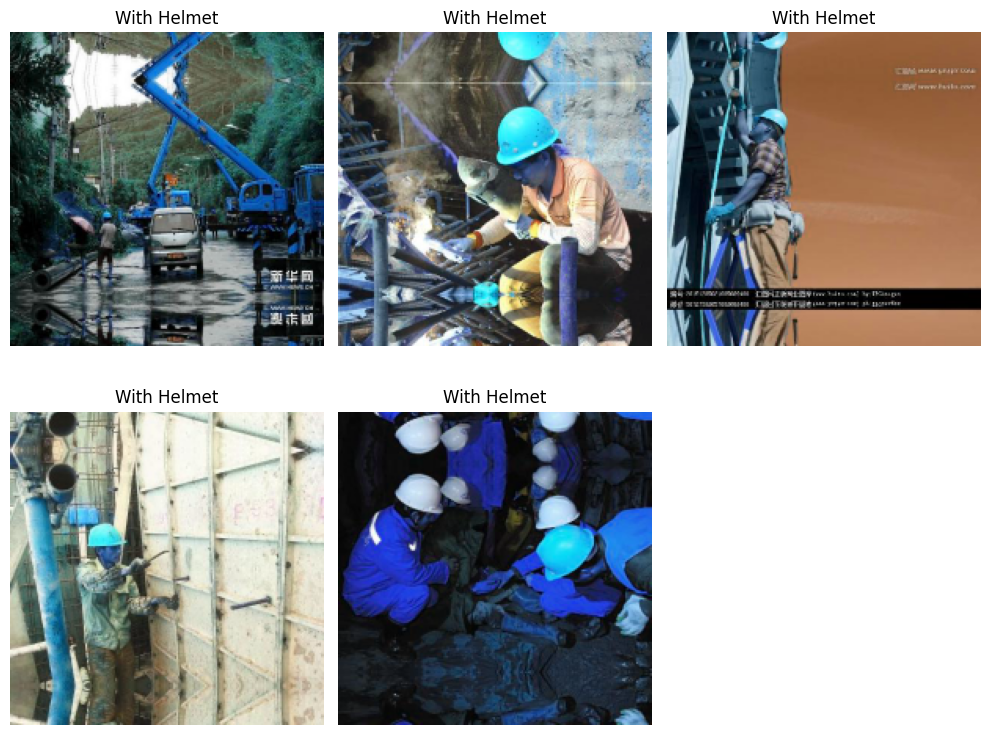

In [ ]:
#Worker wearing helmet
indices_withHelmet = labels[labels['Label']==1].index.tolist()
fig = plt.figure(figsize=(10, 8))
for i in range(5):
  # Corrected subplot number by adding 1 to i
  ax = fig.add_subplot(2,3,i + 1)
  # Using indices for images with helmets
  ax.imshow(images[indices_withHelmet[i]])
  ax.set_title("With Helmet")
  ax.axis('off')
plt.tight_layout() # Adjust layout
plt.show() # Display the plot

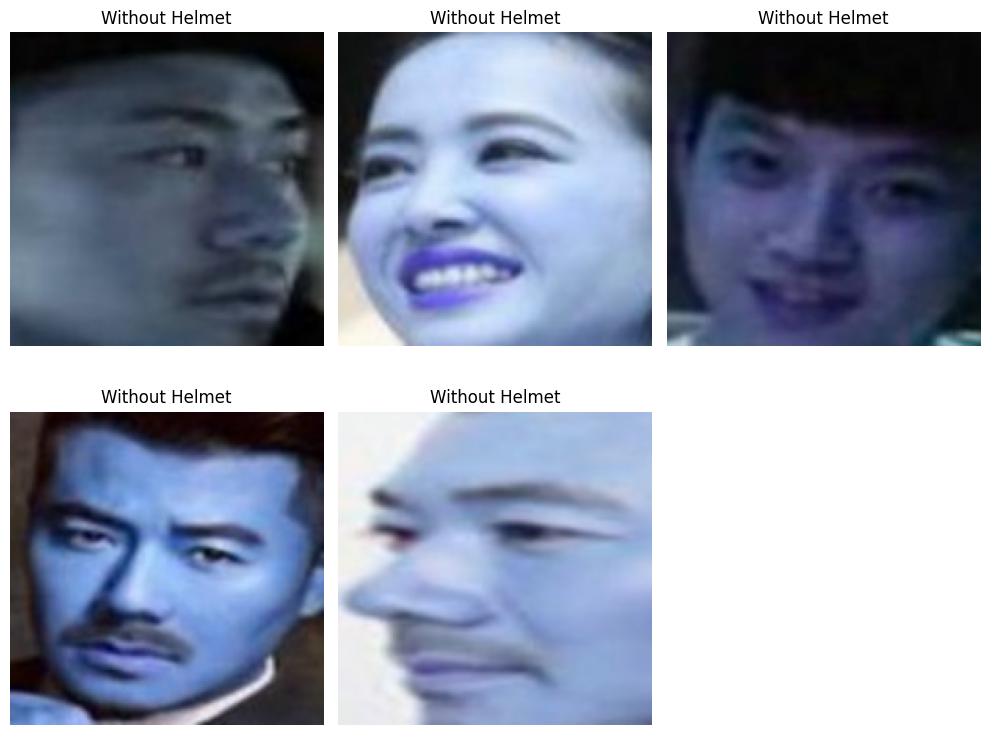

In [ ]:
#Worker not wearing helmet
indices_withoutHelmet = labels[labels['Label']==0].index.tolist()
fig = plt.figure(figsize=(10, 8))
for i in range(5):
  # Corrected subplot number by adding 1 to i
  ax = fig.add_subplot(2,3,i + 1)
  # Using indices for images with helmets
  ax.imshow(images[indices_withoutHelmet[i]])
  ax.set_title("Without Helmet")
  ax.axis('off')
plt.tight_layout() # Adjust layout
plt.show() # Display the plot

## Checking for class imbalance


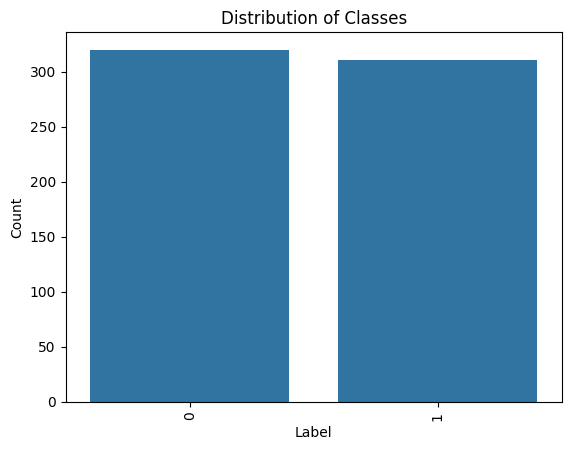

In [ ]:
# Check for class imbalance by counting the occurrences of each label
label_counts = labels['Label'].value_counts()

# Generate a bar plot of the label counts
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation='vertical');
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Classes")
plt.show()

Observations:


*   There is no class imbalance
* The data set is almost equally distributed



# **Data Preprocessing**

## Converting images to grayscale

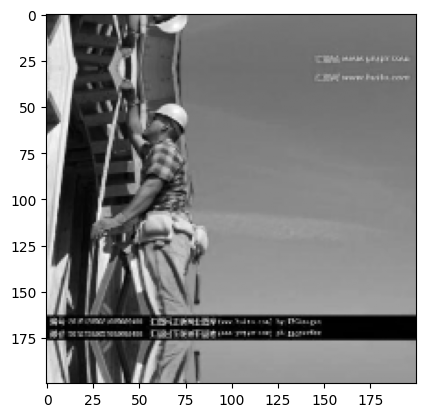

In [ ]:
#converting images to grayscale
grayscale_images = []

for img in images:
  gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  grayscale_images.append(gray_image)

#printing random images for reference
plt.imshow(grayscale_images[2], cmap='gray')
plt.show()

Images are converted to grayscale

### Splitting the dataset



In [ ]:
#Splitting dataset to train and test
x_train,x_temp,y_train,y_temp = train_test_split(np.array(grayscale_images),labels,test_size=0.2,random_state=42,stratify=labels)
x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.5,random_state=42,stratify=y_temp)

In [ ]:
#print the shape of each dataset
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

(504, 200, 200) (504, 1)
(63, 200, 200) (63, 1)
(64, 200, 200) (64, 1)


### Data Normalization

In [ ]:
#Normalising the dataset
X_train_normalised = x_train.astype('float32')/255.0
X_val_normalised = x_val.astype('float32')/255.0
X_test_normalised = x_test.astype('float32')/255.0

# **Model Building**

##Model Evaluation Criterion

## Utility Functions

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [ ]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

In [ ]:
#Clearing Backend
from keras import backend
backend.clear_session()


In [ ]:
#Initialising the model
model_1 = Sequential()

#Adding convolution layer
model_1.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(200,200,1)))

#Adding maxpooling
model_1.add(MaxPooling2D(pool_size=(4,4),padding='same'))

#adding conv layer
model_1.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='same'))

#adding maxpool
model_1.add(MaxPooling2D(pool_size=(4,4),padding='same'))

#Adding conv layer
model_1.add(Conv2D(filters=8,kernel_size=(3,3),activation='relu',padding='same'))
#adding maxpool
model_1.add(MaxPooling2D(pool_size=(4,4), padding='same'))
#adding conv layer
model_1.add(Conv2D(filters=2,kernel_size=(1,1),activation='relu',padding='same'))

#flattening the output
model_1.add(Flatten())

#Adding fully connected layer
model_1.add(Dense(units=100, activation = 'relu'))

#Adding output layer
model_1.add(Dense(units=1, activation='sigmoid'))

#using SGD optimiser
opt=SGD(learning_rate=0.01, momentum=0.9)

#Compiling the model
model_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

#Generate model summary
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 2)        │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,523 (37.20 KB)

 Trainable params: 9,523 (37.20 KB)

 Non-trainable params: 0 (0.00 B)

Fitting the model

In [ ]:
history_1 = model_1.fit(X_train_normalised,y_train, epochs=15,batch_size=25,verbose=2, validation_data=(X_val_normalised, y_val))

Epoch 1/15
21/21 - 7s - 342ms/step - accuracy: 0.5833 - loss: 0.6806 - val_accuracy: 0.5556 - val_loss: 0.6575
Epoch 2/15
21/21 - 0s - 16ms/step - accuracy: 0.6687 - loss: 0.6444 - val_accuracy: 0.5079 - val_loss: 0.6120
Epoch 3/15
21/21 - 0s - 16ms/step - accuracy: 0.8075 - loss: 0.5352 - val_accuracy: 0.8730 - val_loss: 0.3932
Epoch 4/15
21/21 - 1s - 29ms/step - accuracy: 0.9821 - loss: 0.2621 - val_accuracy: 1.0000 - val_loss: 0.1811
Epoch 5/15
21/21 - 1s - 31ms/step - accuracy: 0.8988 - loss: 0.2861 - val_accuracy: 0.8254 - val_loss: 0.3645
Epoch 6/15
21/21 - 0s - 16ms/step - accuracy: 0.9683 - loss: 0.1436 - val_accuracy: 1.0000 - val_loss: 0.0523
Epoch 7/15
21/21 - 1s - 28ms/step - accuracy: 0.9901 - loss: 0.0561 - val_accuracy: 0.9524 - val_loss: 0.1095
Epoch 8/15
21/21 - 0s - 17ms/step - accuracy: 0.9821 - loss: 0.0709 - val_accuracy: 1.0000 - val_loss: 0.0184
Epoch 9/15
21/21 - 0s - 15ms/step - accuracy: 0.9940 - loss: 0.0300 - val_accuracy: 0.9524 - val_loss: 0.0651
Epoch 10/

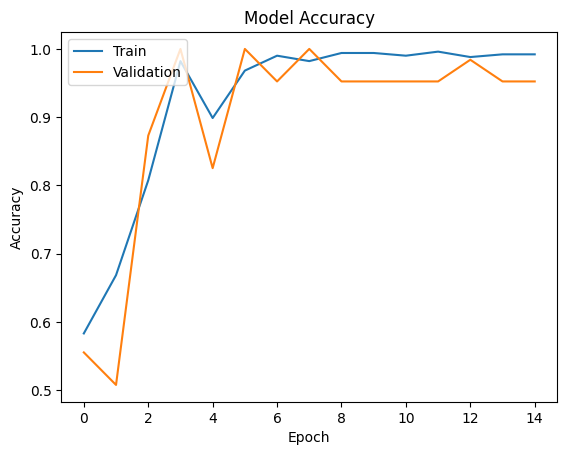

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [ ]:
model_1_train_perf = model_performance_classification(model_1,X_train_normalised,y_train)
print('Training performance metrics')
print(model_1_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.974206  0.974206   0.975453  0.974179


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


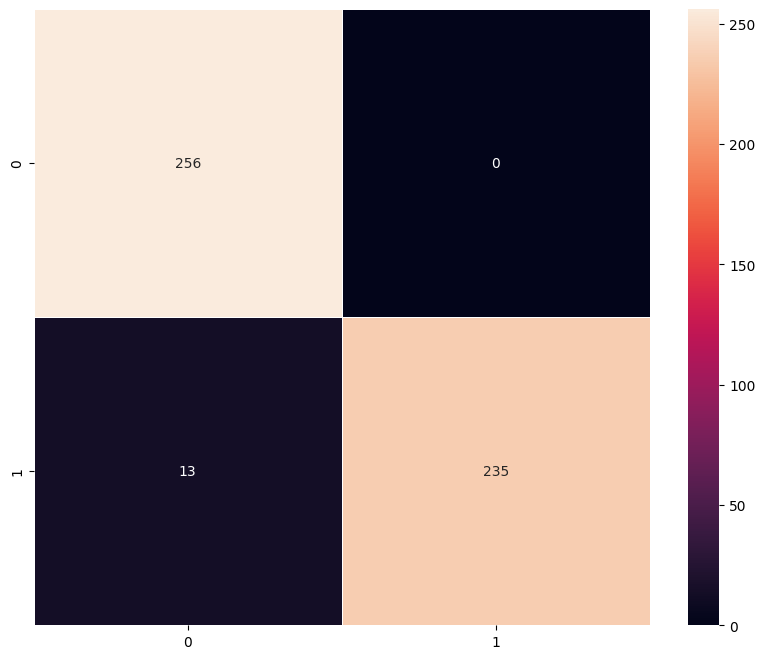

In [ ]:
plot_confusion_matrix(model_1,X_train_normalised,y_train)

In [ ]:
model_1_val_perf = model_performance_classification(model_1,X_val_normalised,y_val)
print('Validation performance metrics')
print(model_1_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Validation performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.952381  0.952381   0.956463  0.952236


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


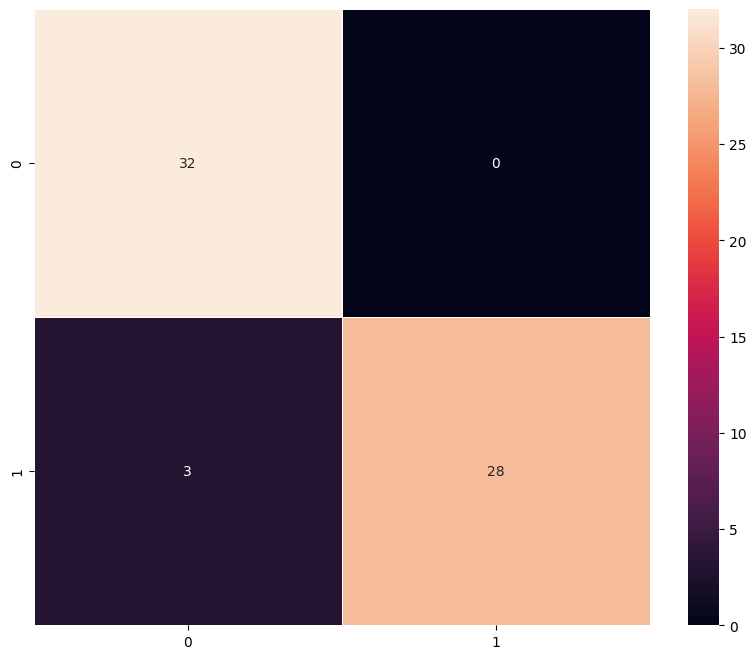

In [ ]:
plot_confusion_matrix(model_1,X_val_normalised,y_val)

Observation
* The model acheived 97% accuracy in training and 95% accuracy in validation
* The model has performed well.

### Vizualizing the predictions

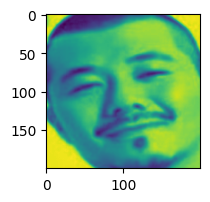

1/1 [==============================] - 0s 76ms/step
Predicted Label 0
True Label 0


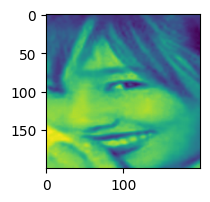

1/1 [==============================] - 0s 77ms/step
Predicted Label 0
True Label 0


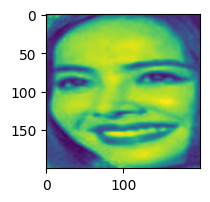

1/1 [==============================] - 0s 55ms/step
Predicted Label 0
True Label 0


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val_normalised[2])
plt.show()
# Reshape the image to include a batch size of 1
predicted_probability = model_1.predict(X_val_normalised[2].reshape(1, 200, 200, 1))[0][0]
pred_label = 1 if predicted_probability >= 0.5 else 0
print('Predicted Label', pred_label)  # reshaping the input image as we are only trying to predict using a single image
print('True Label', (y_val.iloc[2]['Label'])) # Access the label using .iloc and column name


plt.figure(figsize=(2,2))
plt.imshow(X_val_normalised[24])
plt.show()
# Reshape the image to include a batch size of 1
predicted_probability = model_1.predict(X_val_normalised[24].reshape(1, 200, 200, 1))[0][0]
pred_label = 1 if predicted_probability >= 0.5 else 0
print('Predicted Label', pred_label)   # reshaping the input image as we are only trying to predict using a single image
print('True Label', (y_val.iloc[2]['Label'])) # Access the label using .iloc and column name


plt.figure(figsize=(2,2))
plt.imshow(X_val_normalised[15])
plt.show()
# Reshape the image to include a batch size of 1
predicted_probability = model_1.predict(X_val_normalised[15].reshape(1, 200, 200, 1))[0][0]
pred_label = 1 if predicted_probability >= 0.5 else 0
print('Predicted Label', pred_label)   # reshaping the input image as we are only trying to predict using a single image
print('True Label', (y_val.iloc[2]['Label'])) # Access the label using .iloc and column name

## Model 2: (VGG-16 (Base))

In [ ]:
#Splitting dataset to train and test
x_train,x_temp,y_train,y_temp = train_test_split(np.array(images),labels,test_size=0.2,random_state=42,stratify=labels)
x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.5,random_state=42,stratify=y_temp)

In [ ]:
#Normalising the dataset
X_train_normalised = x_train.astype('float32')/255.0
X_val_normalised = x_val.astype('float32')/255.0
X_test_normalised = x_test.astype('float32')/255.0

In [ ]:
# #setting up VGG-16 model
# #vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(200,200,3))
# # Summary of the whole model
# vgg_model = VGG16(weights='imagenet')
# vgg_model.summary()


In [ ]:
# # Getting only the conv layers for transfer learning.
# transfer_layer = vgg_model.get_layer('block5_pool')
# vgg_model_1 = Model(inputs=vgg_model.input, outputs=transfer_layer.output)

In [ ]:
# vgg_model_1.summary()

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (200,200,3))
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Freezing the trainable layers
for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
model_2 = Sequential()

#add convolution layer
model_2.add(vgg_model)

#add flatten layer
model_2.add(Flatten())

# Adding a dense output layer
# model_2.add(Dense(32, activation='relu'))
# model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [ ]:
opt =Adam()
#Compiling the model
# model_2.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy', 'recall', 'precision', 'f1score'])
# Re-compiling model_2 with corrected metrics
model_2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
#summarise the model
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
train_datagen = ImageDataGenerator()

In [ ]:
# Epochs
epochs = 5
# Batch size
batch_size = 128

#X_train_normalised = X_train_normalised.reshape((X_train_normalised.shape[0], 200, 200, 1))

history_vgg16 = model_2.fit(train_datagen.flow(X_train_normalised,y_train,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalised.shape[0] // batch_size,
                    validation_data=(X_val_normalised,y_val),
                    verbose=1)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5227 - loss: 0.6578 - val_accuracy: 1.0000 - val_loss: 0.2318
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9922 - loss: 0.2433 - val_accuracy: 1.0000 - val_loss: 0.1733
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 593ms/step - accuracy: 0.9958 - loss: 0.1435 - val_accuracy: 1.0000 - val_loss: 0.0532
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 1.0000 - loss: 0.0557 - val_accuracy: 1.0000 - val_loss: 0.0442
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step - accuracy: 1.0000 - loss: 0.0349 - val_accuracy: 1.0000 - val_loss: 0.0299


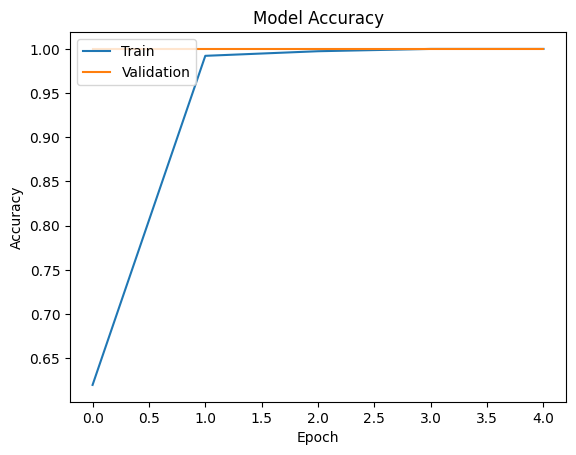

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_2_train_perf = model_performance_classification(model_2, X_train_normalised,y_train)

print("Train performance metrics")
print(model_2_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step


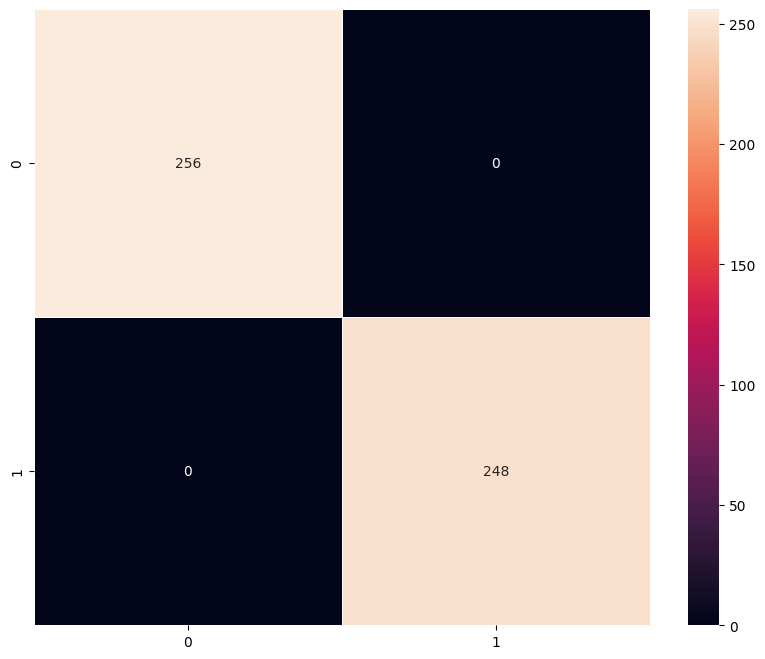

In [ ]:
plot_confusion_matrix(model_2,X_train_normalised,y_train)

In [ ]:
model_2_val_perf = model_performance_classification(model_2, X_val_normalised,y_val)

print("Train performance metrics")
print(model_2_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


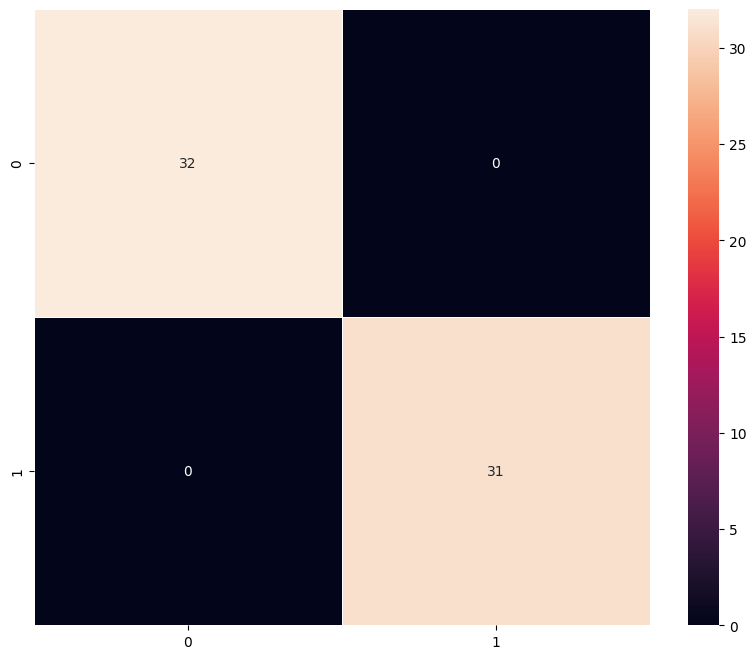

In [ ]:
plot_confusion_matrix(model_2,X_val_normalised,y_val)

The model has acheived 100% accuracy with VGG16 (Base) model in both training and validation dataset

### Visualizing the prediction:

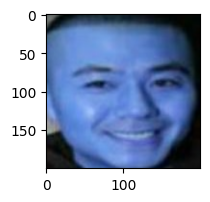

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Predicted Label 0
True Label 0


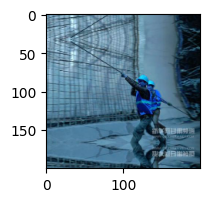

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Label 0
True Label 0


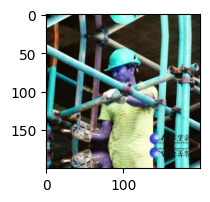

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Label 1
True Label 0


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test_normalised[2])
plt.show()
# Reshape the image to include a batch size of 1
predicted_probability = model_2.predict(X_test_normalised[2].reshape(1, 200, 200, 3))[0][0]
pred_label = 1 if predicted_probability >= 0.5 else 0
print('Predicted Label', pred_label)  # reshaping the input image as we are only trying to predict using a single image
print('True Label', (y_val.iloc[2]['Label'])) # Access the label using .iloc and column name


plt.figure(figsize=(2,2))
plt.imshow(X_test_normalised[24])
plt.show()
# Reshape the image to include a batch size of 1
predicted_probability = model_2.predict(X_test_normalised[17].reshape(1, 200, 200, 3))[0][0]
pred_label = 1 if predicted_probability >= 0.5 else 0
print('Predicted Label', pred_label)   # reshaping the input image as we are only trying to predict using a single image
print('True Label', (y_val.iloc[2]['Label'])) # Access the label using .iloc and column name


plt.figure(figsize=(2,2))
plt.imshow(X_test_normalised[15])
plt.show()
# Reshape the image to include a batch size of 1
predicted_probability = model_2.predict(X_test_normalised[15].reshape(1, 200, 200, 3))[0][0]
pred_label = 1 if predicted_probability >= 0.5 else 0
print('Predicted Label', pred_label)   # reshaping the input image as we are only trying to predict using a single image
print('True Label', (y_val.iloc[2]['Label'])) # Access the label using .iloc and column name

## Model 3: (VGG-16 (Base + FFNN))

In [ ]:
model_3 = Sequential()

#add convolution layer
model_3.add(vgg_model)

#add flatten layer
model_3.add(Flatten())

# Adding a dense output layer
model_3.add(Dense(32, activation='relu'))
model_3.add(Dropout(rate=0.4))
model_3.add(Dense(1, activation='sigmoid'))

In [ ]:
opt =Adam()
#Compiling the model
model_3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#Get the summary
model_3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,304,577 (58.38 MB)

 Trainable params: 589,889 (2.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Epochs
epochs = 5
# Batch size
batch_size = 128

#X_train_normalised = X_train_normalised.reshape((X_train_normalised.shape[0], 200, 200, 1))

history_vgg16 = model_3.fit(train_datagen.flow(X_train_normalised,y_train,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalised.shape[0] // batch_size,
                    validation_data=(X_val_normalised,y_val),
                    verbose=1)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5530 - loss: 0.7163 - val_accuracy: 0.8254 - val_loss: 0.2840
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.8828 - loss: 0.2884 - val_accuracy: 1.0000 - val_loss: 0.0760
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 566ms/step - accuracy: 0.9846 - loss: 0.0691 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9844 - loss: 0.0426 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 612ms/step - accuracy: 0.9977 - loss: 0.0289 - val_accuracy: 1.0000 - val_loss: 0.0012


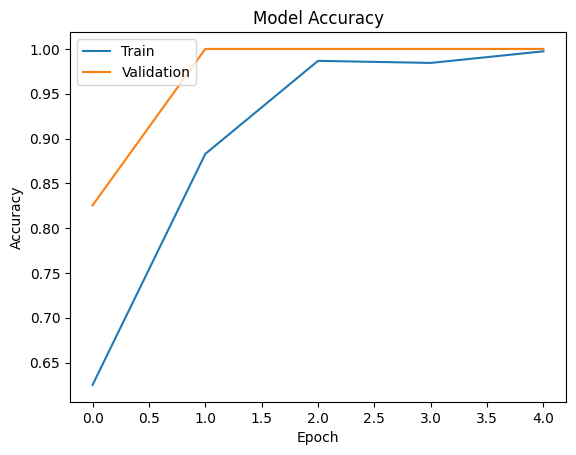

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_3_train_perf = model_performance_classification(model_3, X_train_normalised,y_train)

print("Train performance metrics")
print(model_3_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step


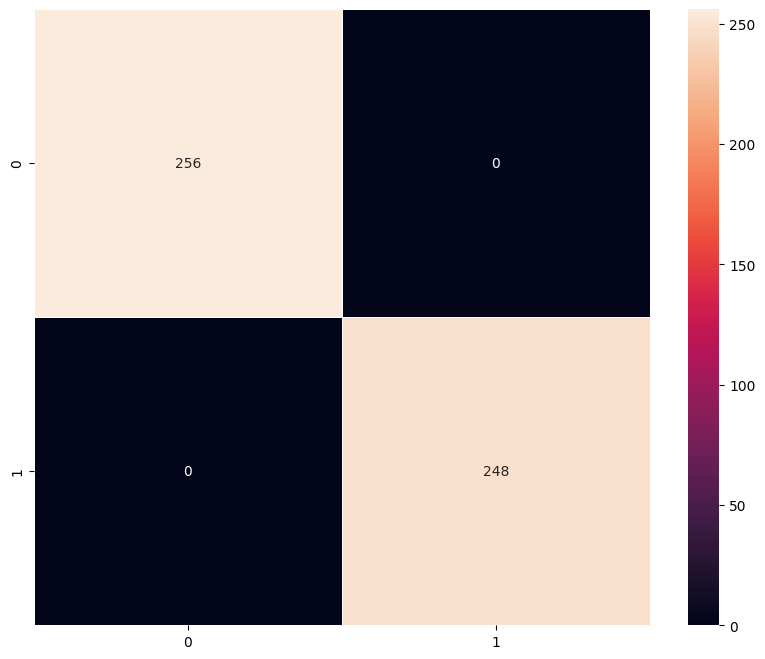

In [ ]:
plot_confusion_matrix(model_3,X_train_normalised,y_train)

In [ ]:
model_3_val_perf = model_performance_classification(model_3, X_val_normalised,y_val)

print("Train performance metrics")
print(model_3_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


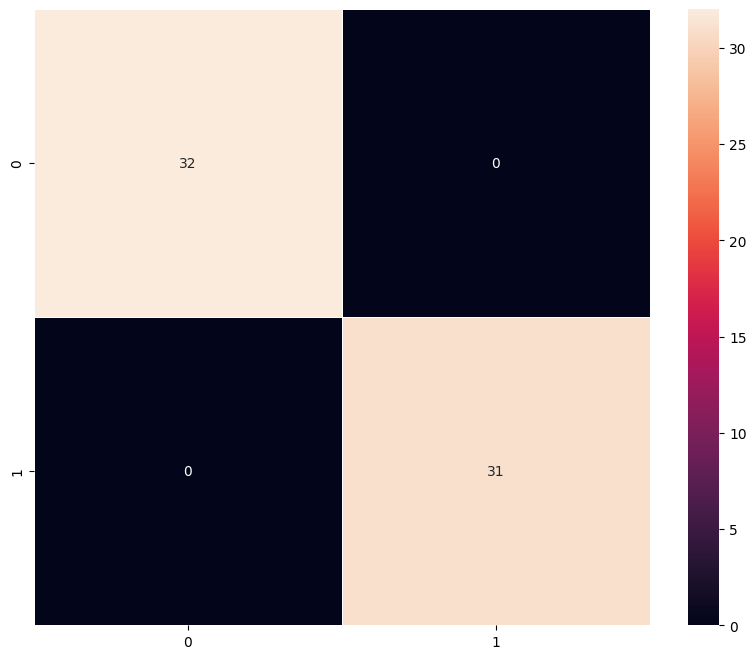

In [ ]:
plot_confusion_matrix(model_3,X_val_normalised,y_val)

- The model using vgg16 with FNN has achieved 100% accuracy on the training set and validation set.

#### Visualizing the predictions

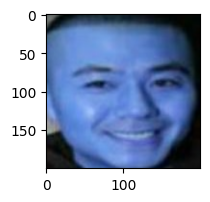

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Label 0
True Label 0


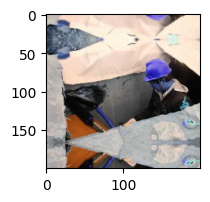

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Label 1
True Label 1


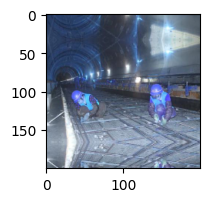

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Label 1
True Label 0


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test_normalised[2])
plt.show()
# Reshape the image to include a batch size of 1
predicted_probability = model_3.predict(X_test_normalised[2].reshape(1, 200, 200, 3))[0][0]
pred_label = 1 if predicted_probability >= 0.5 else 0
print('Predicted Label', pred_label)  # reshaping the input image as we are only trying to predict using a single image
print('True Label', (y_val.iloc[2]['Label'])) # Access the label using .iloc and column name


plt.figure(figsize=(2,2))
plt.imshow(X_test_normalised[12])
plt.show()
# Reshape the image to include a batch size of 1
predicted_probability = model_3.predict(X_test_normalised[12].reshape(1, 200, 200, 3))[0][0]
pred_label = 1 if predicted_probability >= 0.5 else 0
print('Predicted Label', pred_label)   # reshaping the input image as we are only trying to predict using a single image
print('True Label', (y_val.iloc[12]['Label'])) # Access the label using .iloc and column name


plt.figure(figsize=(2,2))
plt.imshow(X_test_normalised[8])
plt.show()
# Reshape the image to include a batch size of 1
predicted_probability = model_3.predict(X_test_normalised[8].reshape(1, 200, 200, 3))[0][0]
pred_label = 1 if predicted_probability >= 0.5 else 0
print('Predicted Label', pred_label)   # reshaping the input image as we are only trying to predict using a single image
print('True Label', (y_val.iloc[8]['Label'])) # Access the label using .iloc and column name

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.1,
                              width_shift_range=0.1,
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.1)
#test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
model_4 = Sequential()

#add convolution layer
model_4.add(vgg_model)

#add flatten layer
model_4.add(Flatten())

# Adding a dense output layer
model_4.add(Dense(32, activation='relu'))
model_4.add(Dropout(rate=0.4))
model_4.add(Dense(1, activation='sigmoid'))

In [ ]:
opt =Adam()
#Compiling the model
model_4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#Get the summary
model_4.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,304,577 (58.38 MB)

 Trainable params: 589,889 (2.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Epochs
epochs = 10
# Batch size
batch_size = 128

#X_train_normalised = X_train_normalised.reshape((X_train_normalised.shape[0], 200, 200, 1))

history_vgg16 = model_4.fit(train_datagen.flow(X_train_normalised,y_train,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalised.shape[0] // batch_size,
                    validation_data=(X_val_normalised,y_val),
                    verbose=1)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5159 - loss: 1.0284 - val_accuracy: 0.4444 - val_loss: 0.7465
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.5703 - loss: 0.6936 - val_accuracy: 0.4921 - val_loss: 0.7470
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4980 - loss: 0.7388 - val_accuracy: 0.4921 - val_loss: 0.7502
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.4667 - loss: 0.7211 - val_accuracy: 0.4921 - val_loss: 0.7475
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4695 - loss: 0.7315 - val_accuracy: 0.4921 - val_loss: 0.7363
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.5547 - loss: 0.7013 - val_accuracy: 0.4921 - val_loss: 0.7330
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4934 - loss: 0.6992 - val_accuracy: 0.4286 - val_loss: 0.7254
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.4766 - loss: 0.7010 - val_accuracy: 0.4127 - val_loss: 0.7235
Epo

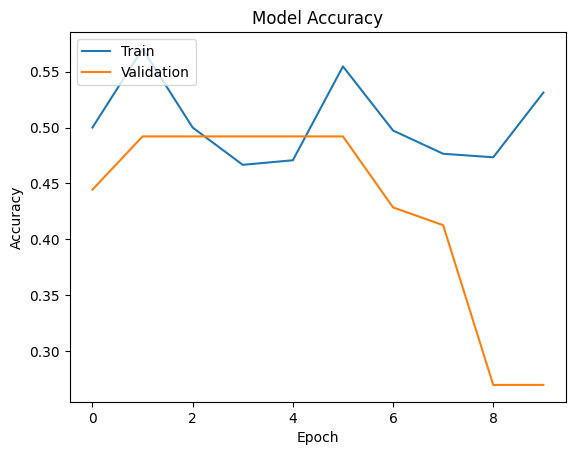

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_4_train_perf = model_performance_classification(model_4, X_train_normalised,y_train)

print("Train performance metrics")
print(model_4_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step
Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.220238  0.220238   0.203858  0.208717


#### Visualizing the predictions

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step


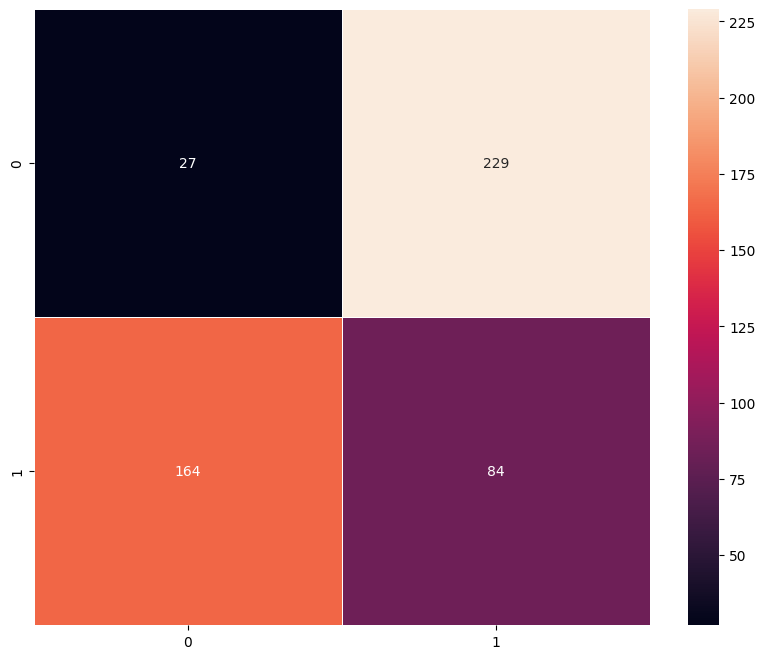

In [ ]:
plot_confusion_matrix(model_4,X_train_normalised,y_train)

In [ ]:
model_4_val_perf = model_performance_classification(model_4, X_val_normalised,y_val)

print("Train performance metrics")
print(model_4_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.269841  0.269841   0.257224   0.25941


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


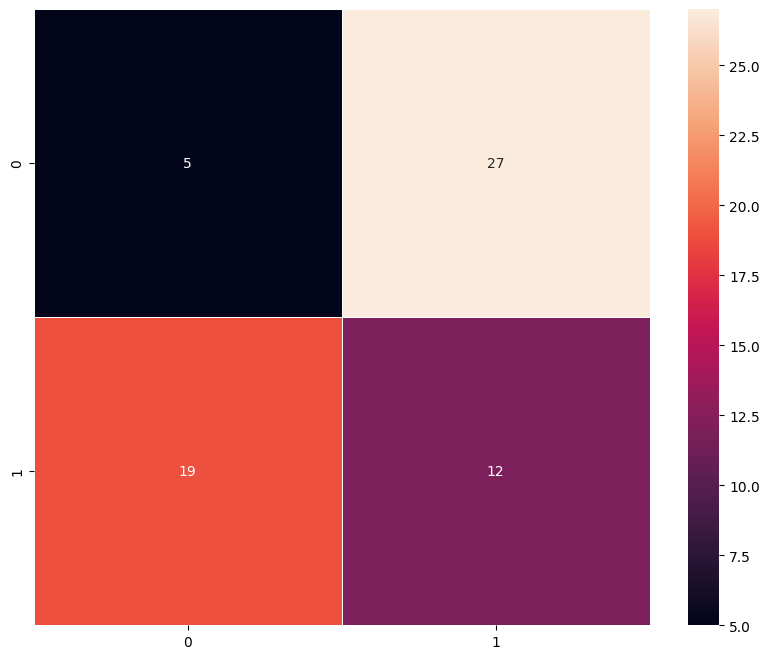

In [ ]:
plot_confusion_matrix(model_4,X_val_normalised,y_val)

The model using VGG-16 (Base + FFNN + Data Augmentation) has not performed well.
It has 22% accuracy in training and 20% accuracy in validation dataset.

# **Model Performance Comparison and Final Model Selection**

In [ ]:
#Performance comparisons
model_training_comb = pd.concat(
    [
    model_1_train_perf.T,
    model_2_train_perf.T,
    model_3_train_perf.T,
    model_4_train_perf.T,
    ],
    axis=1,
)
model_training_comb.columns = [
    "SimpleCNN","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [ ]:
#Performance comparisons
model_val_comb = pd.concat(
    [
    model_1_val_perf.T,
    model_2_val_perf.T,
    model_3_val_perf.T,
    model_4_val_perf.T,
    ],
    axis=1,
)
model_val_comb.columns = [
    "SimpleCNN","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [ ]:
model_training_comb

,SimpleCNN,VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.974206,1.0,1.0,0.220238
Recall,0.974206,1.0,1.0,0.220238
Precision,0.975453,1.0,1.0,0.203858
F1 Score,0.974179,1.0,1.0,0.208717


In [ ]:
model_val_comb

,SimpleCNN,VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.952381,1.0,1.0,0.269841
Recall,0.952381,1.0,1.0,0.269841
Precision,0.956463,1.0,1.0,0.257224
F1 Score,0.952236,1.0,1.0,0.259410


In [ ]:
model_training_comb - model_val_comb

,SimpleCNN,VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.021825,0.0,0.0,-0.049603
Recall,0.021825,0.0,0.0,-0.049603
Precision,0.018990,0.0,0.0,-0.053366
F1 Score,0.021942,0.0,0.0,-0.050693




*   VGG-16 (Base)	and VGG-16 (Base+FFNN) has performed very well in
training and validation data set.
*   Though VGG-16 (Base+FFNN) has performed same as VGG-16 (Base), it is slightly complex  due to added dense layer and dropout.
*   So, let's go with the simple VGG-16 (Base) model.




## Test Performance

In [ ]:
model_2_test_perf = model_performance_classification(model_2, X_test_normalised,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


In [ ]:
model_2_test_perf

,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


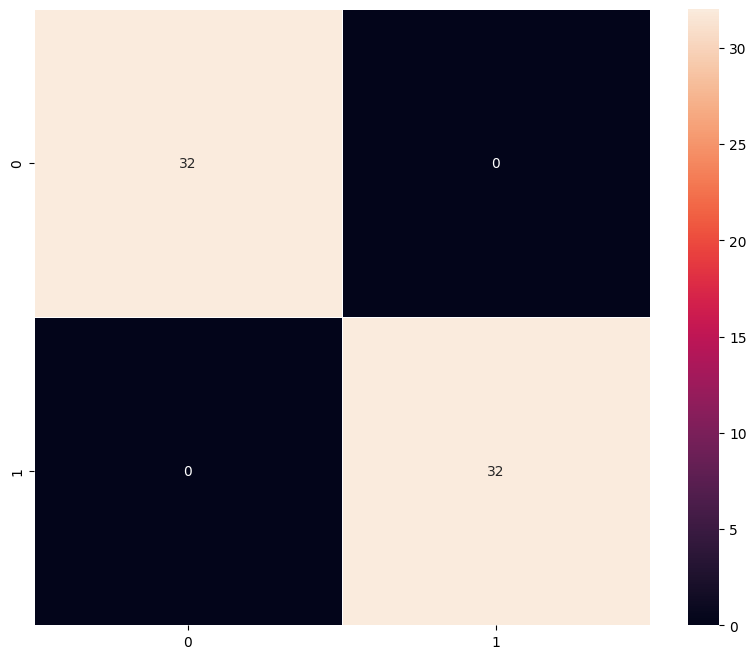

In [ ]:
plot_confusion_matrix(model_2, X_test_normalised,y_test)

The model (VGG16 (Base)) has produced 100% accuracy is test dataset as well

# **Actionable Insights & Recommendations**

---


*   Based on the validation performance, the VGG-16 (Base) and VGG-16 (Base+FFNN) models achieved perfect scores. While the VGG-16 (Base) is simpler and potentially less prone to overfitting on a small dataset, both show great promise. It is crucial to confirm this performance on the unseen test set to ensure the model generalizes well to new data.
*   The perfect 100% accuracy on the validation set for the VGG-16 based models is highly unusual for a real-world image dataset, especially of this size. This could indicate overfitting or potential data leakage between the training and validation sets. While stratify was used during splitting, further investigation into the data splitting process and data loading is recommended to rule out data leakage.
*  The data augmentation applied in Model 4 did not improve performance and resulted in low accuracy. This could be due to the type of augmentations used or their parameters not being suitable for this specific dataset.
*   The performance of the final model (VGG-16 (Base) on the validation set and test set is a good indicator, but the true measure of the model's effectiveness on unseen data is its performance on the real-time data.
*   Real-world deployment environments may have varying lighting conditions, angles, occlusions, and different types of safety helmets. While the dataset descriptions mention variations, evaluating the model's performance on specific challenging scenarios or adding more diverse images to the dataset can improve robustness.
*  For deployment, consider the trade-off between model complexity/inference time and accuracy. A simpler model like VGG-16 Base might be faster for real-time inference compared to more complex architectures.
*   Once deployed, continuously monitoring the model's performance on real-world data and retraining with new data that represents challenging cases will be crucial for maintaining high accuracy and adapting to changing conditions.

